In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
import matplotlib.pyplot as plt
from strategy_implementation import *

df = pd.read_csv("TSLA_weekly_return_volatility.csv")
df_18 = df.loc[df["Year"] == 2018].reset_index()
df_19 = df.loc[df["Year"] == 2019].reset_index()

### 1. Construct an Adaboost classifier with three base estimators. Plot your error rates as N from 1 to 15.

In [2]:
# data
X_train = df_18[["mean_return", "volatility"]].values
Y_train = df_18["label"].values
X_test = df_19[["mean_return", "volatility"]].values
Y_test = df_19["label"].values

# base estimators: logistic regression, naive bayesian, decision tree
log_reg = LogisticRegression()
native_bayesian = GaussianNB()
decision_tree = tree.DecisionTreeClassifier(criterion="entropy")

# N - number of "weak" learners to use - 0.5, 1
# lambda - learning rate - (1 - 15)
N = [ n for n in range(1,16)]
lamdas = [0.5, 1]

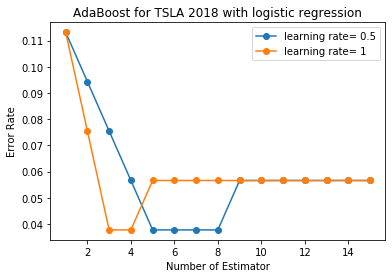

In [3]:
# 1.1 logistic regression
log_error_lists = []
for lam in lamdas:
    errors = []
    for n in N:
        model = AdaBoostClassifier(base_estimator=log_reg, n_estimators=n, learning_rate=lam, random_state=0)
        model.fit(X_train, Y_train)
        y_predict = model.predict(X_test)
        error_rate = np.mean(y_predict != Y_test)
        errors.append(error_rate)
    log_error_lists.append(errors)
plt.plot(N, log_error_lists[0], marker="o", label="learning rate= 0.5")
plt.plot(N, log_error_lists[1], marker="o", label="learning rate= 1")
plt.legend()
plt.xlabel("Number of Estimator")
plt.ylabel("Error Rate")
plt.title("AdaBoost for TSLA 2018 with logistic regression")
plt.show()

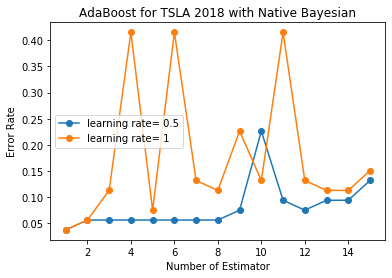

In [4]:
# 1.2 native bayesian
nb_error_lists = []
for lam in lamdas:
    errors = []
    for n in N:
        model = AdaBoostClassifier(base_estimator=native_bayesian, n_estimators=n, learning_rate=lam, random_state=0)
        model.fit(X_train, Y_train)
        y_predict = model.predict(X_test)
        error_rate = np.mean(y_predict != Y_test)
        errors.append(error_rate)
    nb_error_lists.append(errors)
plt.plot(N, nb_error_lists[0], marker="o", label="learning rate= 0.5")
plt.plot(N, nb_error_lists[1], marker="o", label="learning rate= 1")
plt.legend()
plt.xlabel("Number of Estimator")
plt.ylabel("Error Rate")
plt.title("AdaBoost for TSLA 2018 with Native Bayesian")
plt.show()

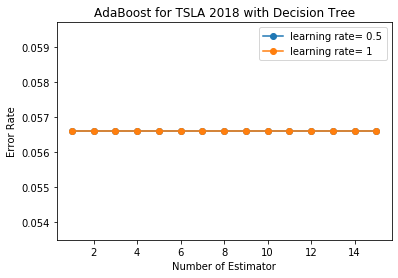

In [5]:
# 1.3 decision tree
dt_error_lists = []
for lam in lamdas:
    errors = []
    for n in N:
        model = AdaBoostClassifier(base_estimator=decision_tree, n_estimators=n, learning_rate=lam, random_state=0)
        model.fit(X_train, Y_train)
        y_predict = model.predict(X_test)
        error_rate = np.mean(y_predict != Y_test)
        errors.append(error_rate)
    dt_error_lists.append(errors)
plt.plot(N, dt_error_lists[0], marker="o", label="learning rate= 0.5")
plt.plot(N, dt_error_lists[1], marker="o", label="learning rate= 1")
plt.legend()
plt.xlabel("Number of Estimator")
plt.ylabel("Error Rate")
plt.title("AdaBoost for TSLA 2018 with Decision Tree")
plt.show()

### 2. Best N value for learning rate = 0.5

In [6]:
# logistic regreesion
log_min_error = min(log_error_lists[0])
log_n = np.where(log_error_lists[0] == log_min_error)[0][0] + 1

# native bayesian
nb_min_error = min(nb_error_lists[0])
nb_n = np.where(nb_error_lists[0] == nb_min_error)[0][0] + 1

# decision tree
dt_min_error = min(dt_error_lists[0])
dt_n = np.where(dt_error_lists[0] == dt_min_error)[0][0] + 1

print("For learning rate equal to 0.5: \nthe best N for logistic regresion is", log_n,
     "\nthe best N for native bayesian is", nb_n,
     "\nthe best N for decision tree is", dt_n)

For learning rate equal to 0.5: 
the best N for logistic regresion is 5 
the best N for native bayesian is 1 
the best N for decision tree is 1


### 3. Accuracy

In [7]:
# logistic regreesion
log_acc = 1 - log_min_error

# native bayesian
nb_acc = 1 - nb_min_error

# decision tree
dt_acc = 1 - dt_min_error 

print("With learning rate equal to 0.5 and the best N for each estimator:\
\nthe accuracy for logistic regresion is", round(log_acc,2),
      "\nthe accuracy for native bayesian is", round(nb_acc,2),
     "\nthe accuracy for decision tree is", round(dt_acc,2))

With learning rate equal to 0.5 and the best N for each estimator:
the accuracy for logistic regresion is 0.96 
the accuracy for native bayesian is 0.96 
the accuracy for decision tree is 0.94


### 4. What classifier is best to use as base estimator?

Given the error rates and accuracy above, the best classifier to use for estimating TSLA data is logistic regression.

### 5. Implement a trading strategy

In [8]:
df_trade = pd.read_csv("Trade_18_19.csv")
df_trade_19 = df_trade.loc[df_trade["Year"] == 2019].reset_index()
invest = 100

# model
model = AdaBoostClassifier(base_estimator=log_reg, n_estimators=log_n, learning_rate=0.5, random_state=0)
model.fit(X_train, Y_train)
ada_y_predict = model.predict(X_test)

green_week_index = green_week(ada_y_predict)
df_implement = profit_loss_balance(df_trade_19, invest, green_week_index)
ada_final_value = final_balance(df_implement)
print("The final value of balance with strategy implementation is", ada_final_value)

The final value of balance with strategy implementation is 449.76


In [9]:
# original label 
green_week_orginal = Y_test.tolist()
green_week_original_index = green_week(green_week_orginal)
df_original = profit_loss_balance(df_trade_19, invest, green_week_original_index)
original_final_value = final_balance(df_original)
print("The final value of balance with the label strategy is", original_final_value)

# buy-and-hold strategy
adj_close = df_trade_19["Adj Close"].values
buy_in_price = adj_close[0]
close_price = adj_close[-1]
buy_hold_final_value = buy_hold(invest, buy_in_price, close_price)
print("The final value of balance with the buy-and-hold strategy is", buy_hold_final_value)

The final value of balance with the label strategy is 456.7
The final value of balance with the buy-and-hold strategy is 134.89


The AdaBoost strategy implementation results in similar value as the original label strategy.